In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

from datetime import timedelta, datetime as dt
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import Holt

In [48]:
df = pd.read_csv('saas.csv')

In [49]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [50]:
df.Amount.value_counts()

0.0     496410
5.0     178212
10.0     70706
15.0     26474
20.0     18656
Name: Amount, dtype: int64

In [51]:
df.Subscription_Type.value_counts()

0.0    496410
1.0    178212
2.0     70706
3.0     26474
4.0     18656
Name: Subscription_Type, dtype: int64

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [36]:
df.describe()

,Customer_Id,Invoice_Id,Subscription_Type,Amount
count,7.904580e+05,7.904580e+05,790458.000000,790458.000000
mean,1.012913e+06,5.395228e+06,0.599235,2.996174
std,7.591992e+03,2.281857e+05,0.950380,4.751901
min,1.000000e+06,5.000000e+06,0.000000,0.000000
25%,1.006405e+06,5.197614e+06,0.000000,0.000000
50%,1.012797e+06,5.395228e+06,0.000000,0.000000
75%,1.019154e+06,5.592843e+06,1.000000,5.000000
max,1.029399e+06,5.790457e+06,4.000000,20.000000


In [37]:
df.shape

(790458, 5)

# 1.Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [53]:
# Have to use parenthesis in order to comment each line
def prep_data(df):
    return(df.assign(m_invoice = pd.to_datetime(df.Month_Invoiced)). # assigned m_invoice as the new varible 
    # to have date time assigned
    sort_values('m_invoice'). # Sorting values by the m_invoice
    reset_index().set_index('m_invoice') # index set to m_invoice
    [['Amount']]. # Selecting only the amount column to sum
    resample('M').sum()) # Resampling by month and summing

In [54]:
df = prep_data(df)

In [55]:
df.head()

,Amount
m_invoice,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


In [56]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df[: train_size]
validate = df[train_size : validate_end_index]
test = df[validate_end_index : ]

In [57]:
print(len(train) + len(validate) + len(test) == len(df))

True


In [58]:
print(df.head(1) == train.head(1))

            Amount
m_invoice         
2014-01-31    True


In [59]:
# validating the train validate split
pd.concat([train.tail(1), validate.head(1)])

,Amount
m_invoice,
2015-12-31,51505.0
2016-01-31,51955.0


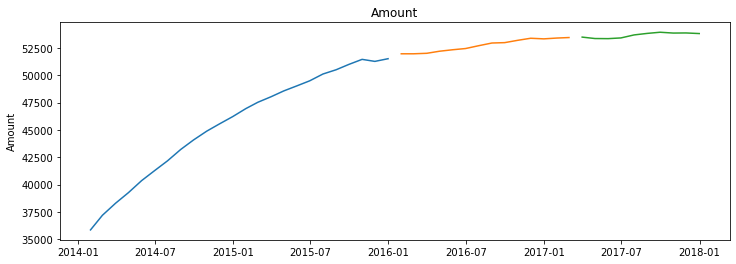

In [60]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

# 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- Simple Average
- Moving Average
- Holt's Linear Trend Model
- Based on previous year/month/etc., this is up to you.


In [61]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


In [62]:
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [63]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

# Forecast
**Last observed value**
The simplest method for forecasting is to predict all future values to be the last observed value.

Make Predictions

In [64]:
train.tail(5)

,Amount
m_invoice,
2015-08-31,50495.0
2015-09-30,50985.0
2015-10-31,51445.0
2015-11-30,51260.0
2015-12-31,51505.0


In [65]:
amount = train['Amount'][-1:][0]
print(amount)
print(sub_type)

51505.0
10301.0


In [66]:
yhat_df = pd.DataFrame({'Amount': [amount]}, index = validate.index)

In [67]:
yhat_df.head()

,Amount
m_invoice,
2016-01-31,51505.0
2016-02-29,51505.0
2016-03-31,51505.0
2016-04-30,51505.0
2016-05-31,51505.0


Amount -- RMSE: 1343


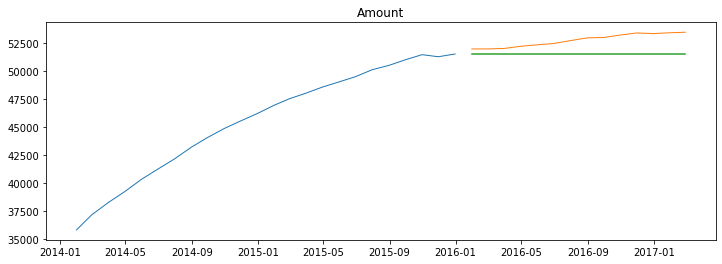

In [68]:
for col in train.columns:
    plot_and_eval(col)

## Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [69]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,Amount,1343.0


# Simple Average
Take the simple average of historical values and use that value to predict future values.

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.

**Make Predictions**

In [70]:
amount = round(train['Amount'].mean(),2)
amount

45568.54

In [71]:
def make_predictions():
    yhat_df = pd.DataFrame({'Amount': [amount]}, index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [72]:
yhat_df.head()

,Amount
m_invoice,
2016-01-31,45568.54
2016-02-29,45568.54
2016-03-31,45568.54
2016-04-30,45568.54
2016-05-31,45568.54


Amount -- RMSE: 7181


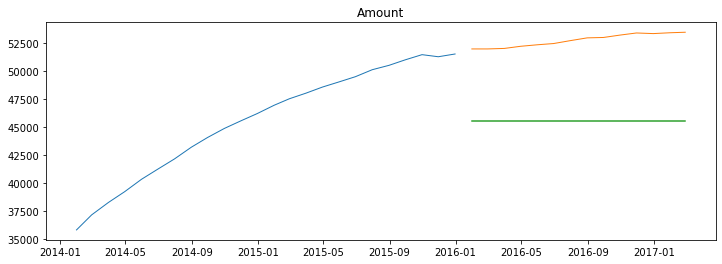

In [73]:
for col in train.columns:
    plot_and_eval(col)

# Moving Average
In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value.

**Make Predictions**

In [84]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 1

amount = train['Amount'].rolling(period).mean()
yhat_df = make_predictions()
yhat_df.head(3)

,Amount
m_invoice,
2016-01-31,m_invoice 2014-01-31 35850.0 2014-02-28 ...
2016-02-29,m_invoice 2014-01-31 35850.0 2014-02-28 ...
2016-03-31,m_invoice 2014-01-31 35850.0 2014-02-28 ...
